# LayoutLMMasked Model

### Author: Ashish Kumar

## Install necessary packages 

In [ ]:
!pip install --upgrade azure-cognitiveservices-vision-computervision
!pip install --upgrade pillow

In [61]:
result = image_pdf_text()

Waiting for result...


## Install pytorch package

In [3]:
!conda install -c pytorch pytorch -y

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - pytorch


The following NEW packages will be INSTALLED:

  pytorch            pytorch/osx-64::pytorch-1.12.1-py3.8_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Install unilm package

In [2]:
! rm -r unilm -y
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! pip install unilm/layoutlm

rm: unilm: No such file or directory
rm: -y: No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 4248, done.
remote: Total 4248 (delta 0), reused 0 (delta 0), pack-reused 4248
Receiving objects: 100% (4248/4248), 7.29 MiB | 3.88 MiB/s, done.
Resolving deltas: 100% (2086/2086), done.
Processing ./unilm/layoutlm
  Preparing metadata (setup.py) ... done
  Using cached transformers-2.9.0-py3-none-any.whl (635 kB)
  Using cached tokenizers-0.7.0-cp38-cp38-macosx_10_10_x86_64.whl (1.2 MB)
  Created wheel for layoutlm: filename=layoutlm-0.0-py3-none-any.whl size=11487 sha256=631c7ce4f266ff77fd95c9cd67ca7b8081485c407c7adcc56dd7821353e2c6b3
  Stored in directory: /private/var/folders/zj/8z_wp5cd7wvb9xv54j_9q6mh0000gn/T/pip-ephem-wheel-cache-vvxyuylr/wheels/23/c2/f4/f30303f8d4897b6ecb9c433bd64f1c14caf7a755dc3a08449b
Successfully built layoutlm
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
     

# Install huggingface transformers

In [3]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! pip install ./transformers

rm: transformers: No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 104376, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 104376 (delta 0), reused 1 (delta 0), pack-reused 104369
Receiving objects: 100% (104376/104376), 97.04 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (77119/77119), done.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tokenizers-0.12.1-cp38-cp38-macosx_10_11_x86_64.whl (3.6 MB)
  Created wheel for transformers: filename=transformers-4.22.0.dev0-py3-none-any.whl size=4703225 sha256=61d391c54b23065ba5e0d77974dbf786b5c15f2a4d5ecdc5f7dc0acb200f0d0e
  Stored in directory: /private/var/folders/zj/8z_wp5cd7wvb9xv54j_9q6mh0000gn/T/pip-ephem-wheel-cache-agg7wg_h/wheels/51/2d/04/ff431b87cba601c09ddcbd84a85208d0982c1431aac041d844
Successfully built 

# Pre-processing

## Normalised bounding box

In [81]:
def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

## MS Azure Computer Vision OCR Funtction

Extract Text PDF - Computer Vision API
This sample will extract printed and handwritten text from images in a PDF.
The images include both printed and handwritten text, including signatures.        

Download the sample PDF here: 
https://github.com/Azure-Samples/cognitive-services-sample-data-files/blob/master/ComputerVision/Images/printed_handwritten.pdf

Place the PDF in your working directory.

Install the Computer Vision SDK:
pip install --upgrade azure-cognitiveservices-vision-computervision

Steps:
   - Authenticate
   - Read and extract from PDF
   - Display extracted text results in console

References: 
Computer Vision Batch Read File documentation: 
https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-recognizing-text
SDK: 
https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision?view=azure-python
API: 
https://westus.dev.cognitive.microsoft.com/docs/services/5cd27ec07268f6c679a3e641/operations/56f91f2e778daf14a499f21b 

## Create MS Azure Computer Services and Access Keys

Below snapshots depicts MS Azure Computer Vision Services and Keys then we need to create in MS Azure portal first

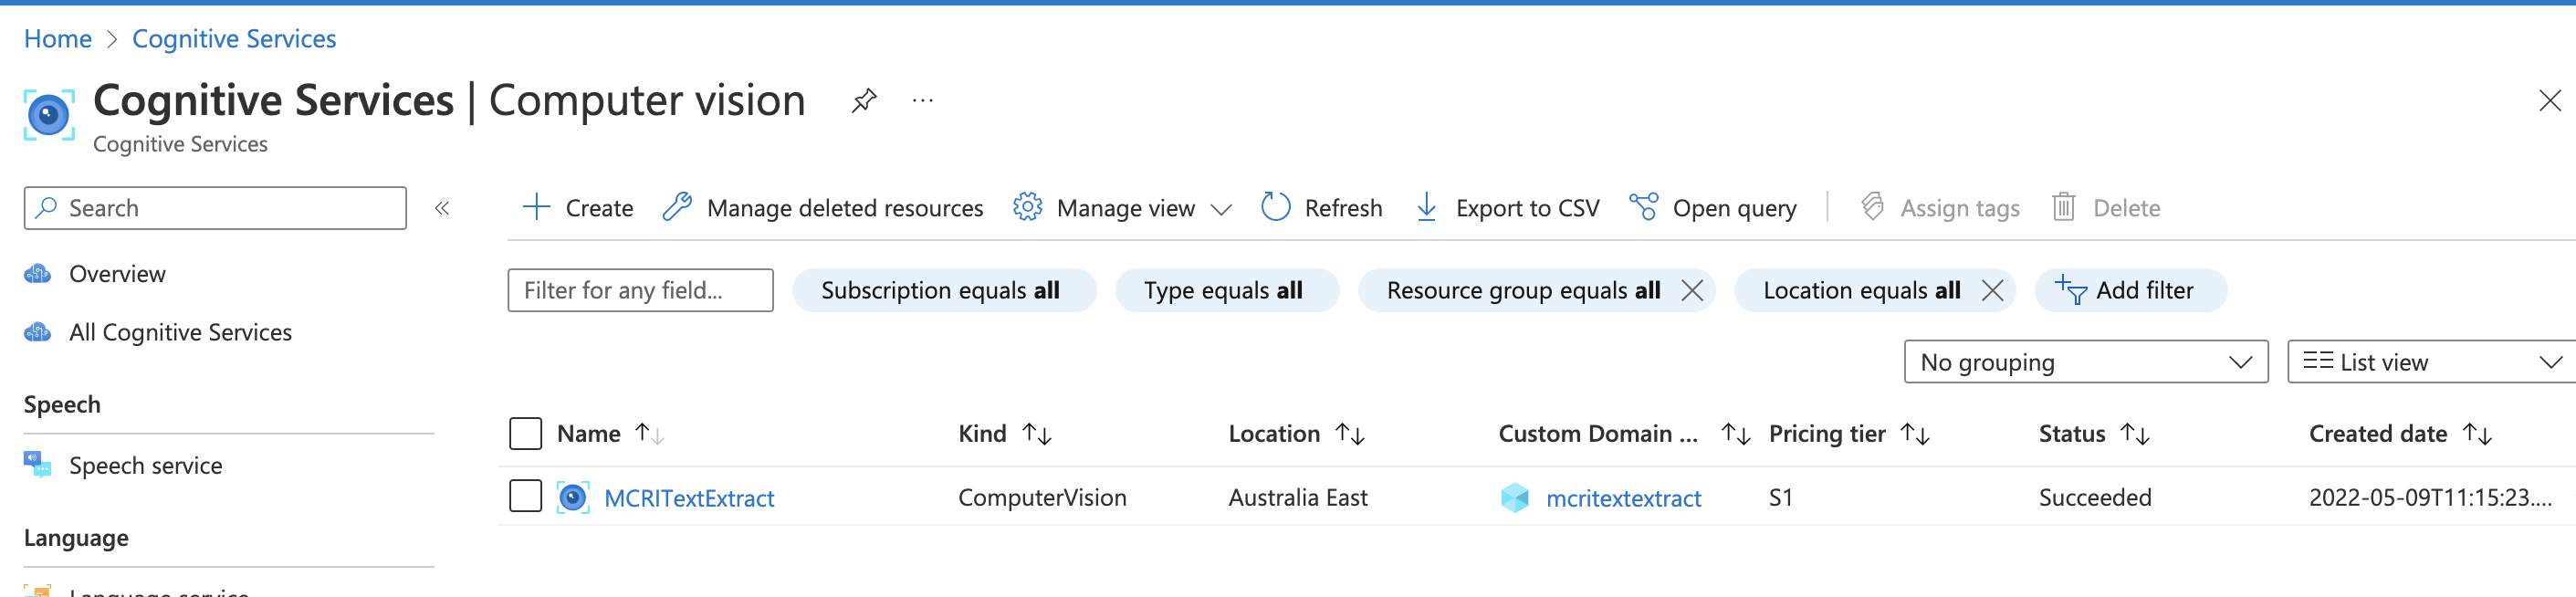


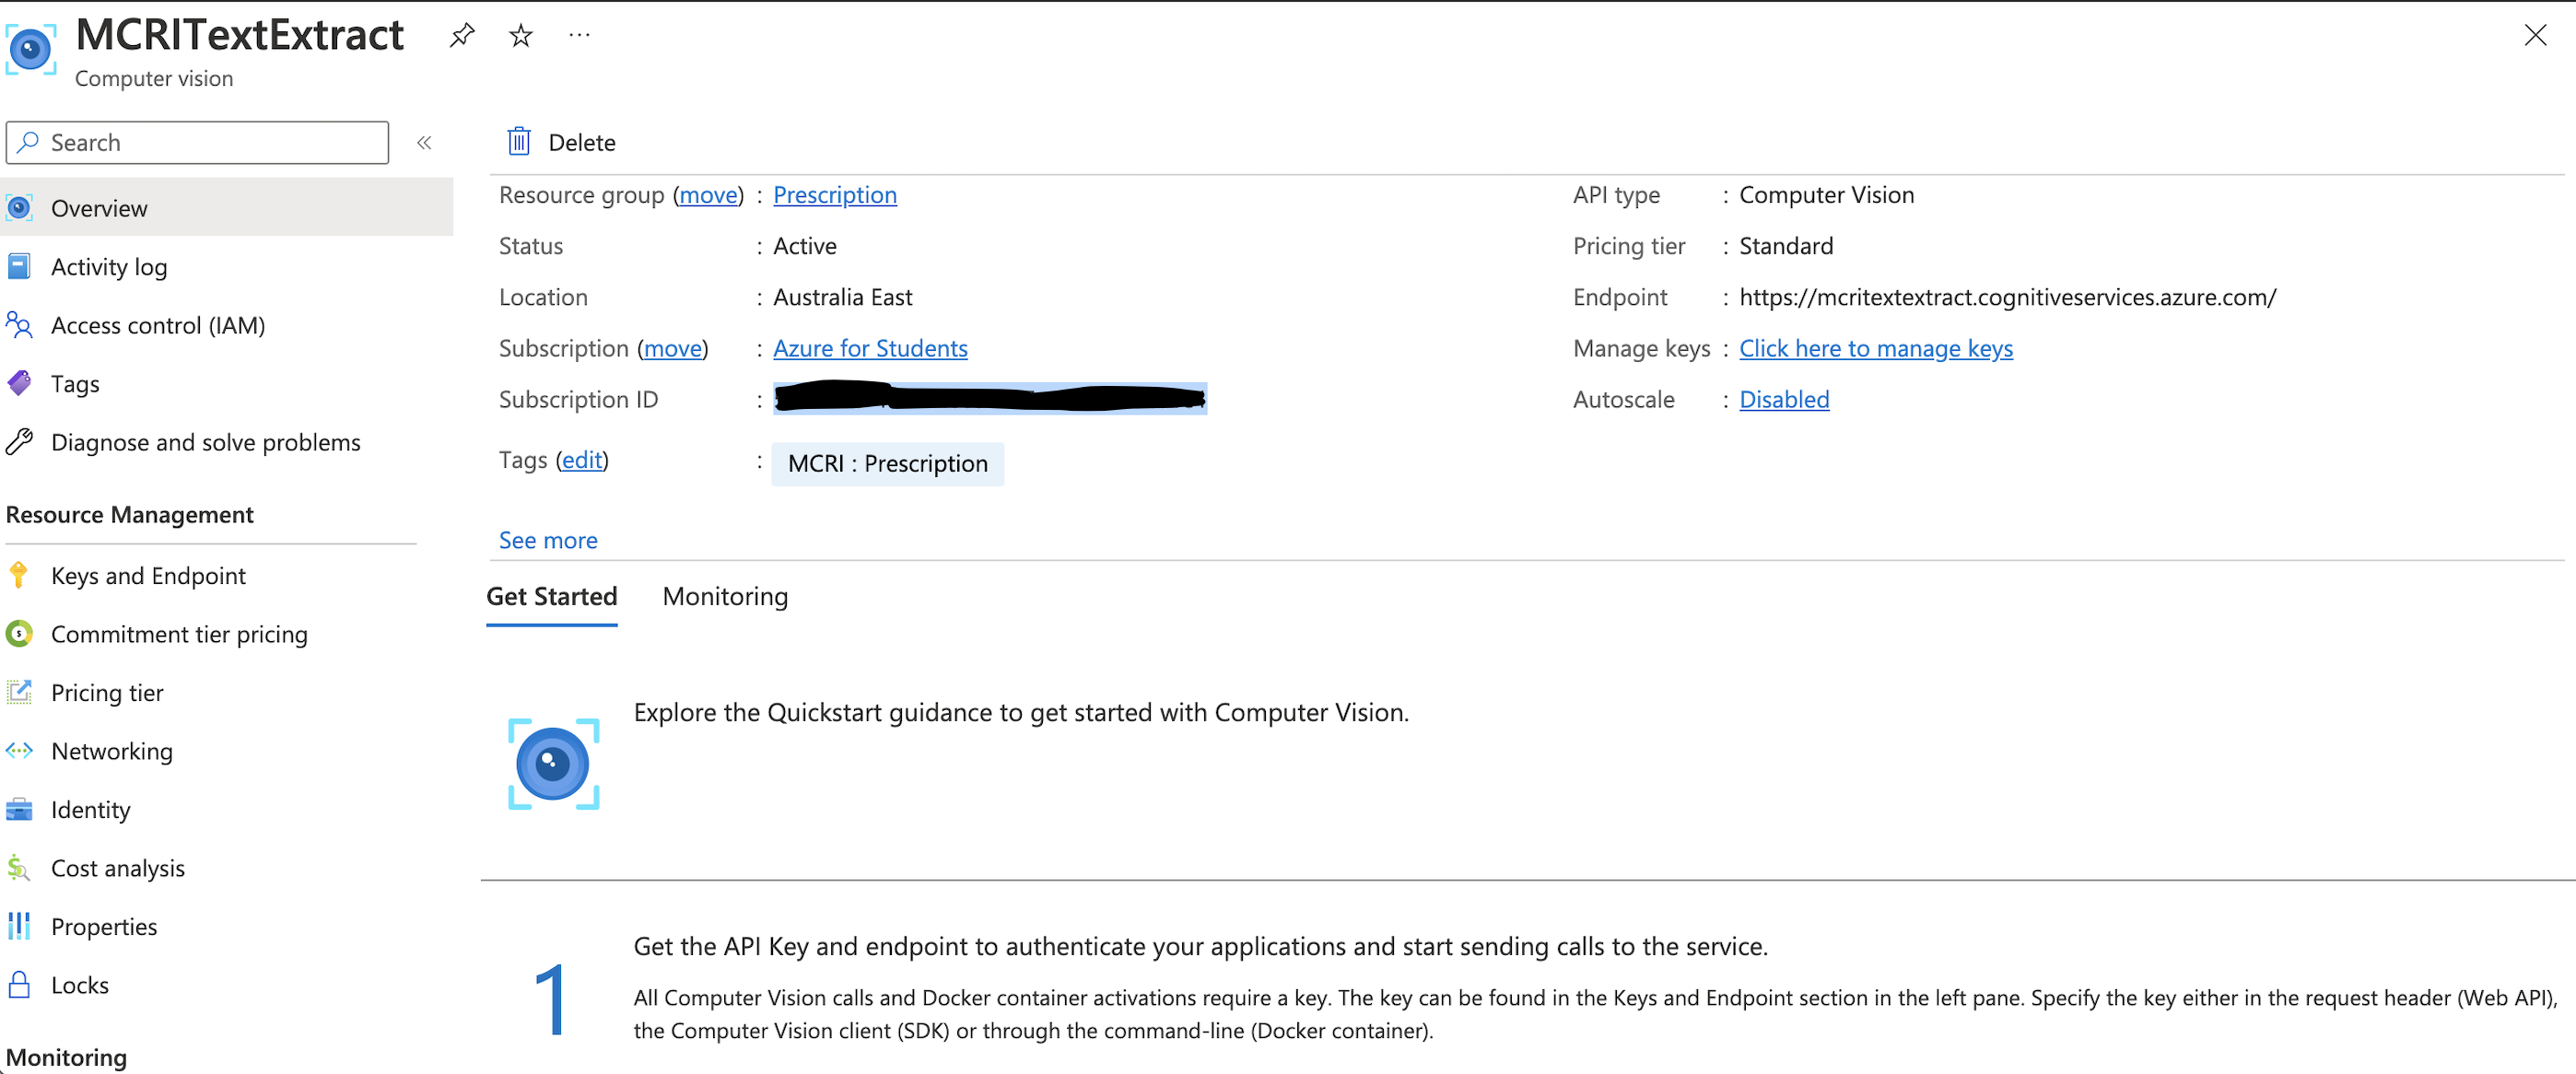

## MS Azure Endpoint and Keys

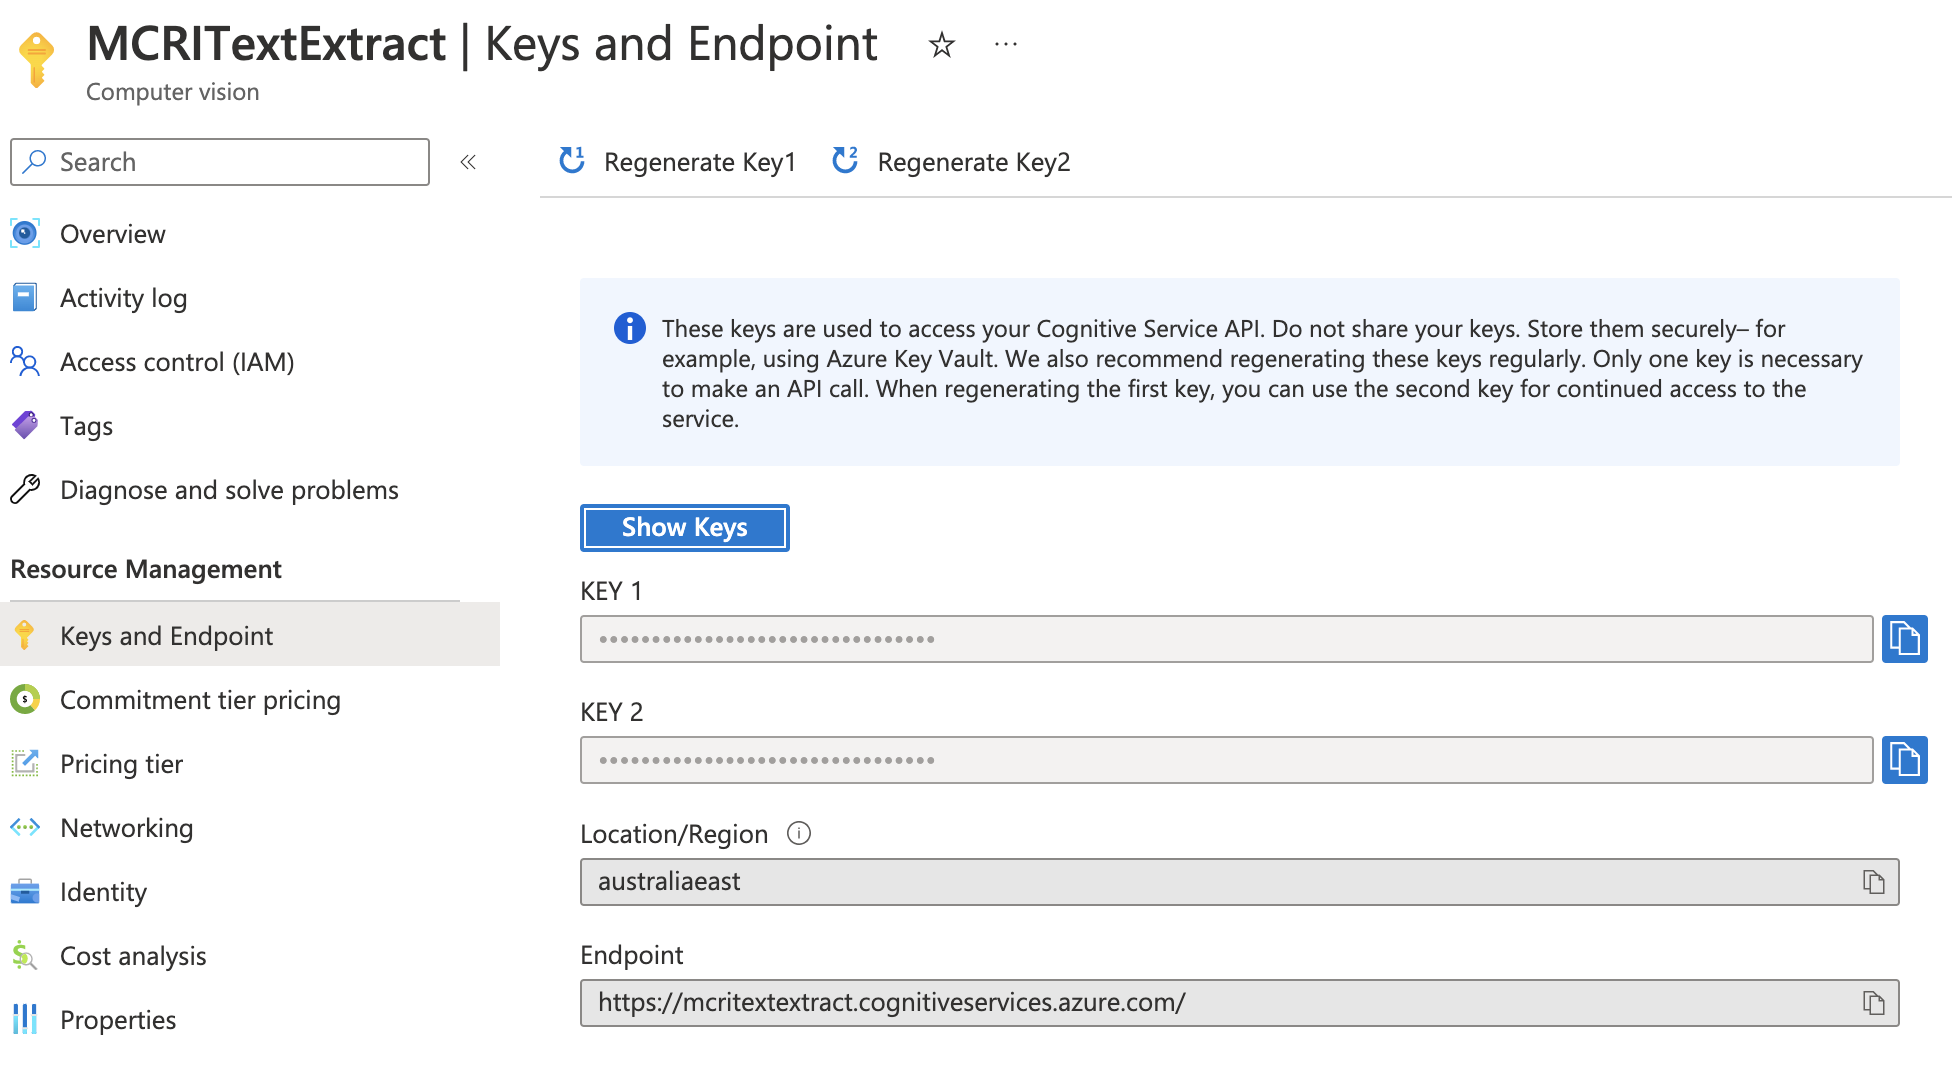

In [194]:
from PIL import Image, ImageDraw, ImageFont
import time, os
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes


#Authenticate
#
key = ''
endpoint = 'https://mcritextextract.cognitiveservices.azure.com/'

# Set credentials
credentials = CognitiveServicesCredentials(key)
# Create client
client = ComputerVisionClient(endpoint, credentials)


def image_pdf_text(image_file):
    # Images PDF with text

    filepath = open(image_file,'rb')

    # Async SDK call that "reads" the image
    response = client.read_in_stream(filepath, raw=True)

    # Don't forget to close the file
    filepath.close()

    # Get ID from returned headers
    operation_location = response.headers["Operation-Location"]
    operation_id = operation_location.split("/")[-1]

    # SDK call that gets what is read
    while True:
        result = client.get_read_result(operation_id)
        if result.status.lower () not in ['notstarted', 'running']:
            break
        print ('Waiting for result...')
        time.sleep(10)
    return result


def apply_ocr(example):
    # get the image
    image = Image.open(example['image_path'])
    
    width, height = image.size
    
    # apply ocr to the image 
    result = image_pdf_text(example['image_path'])
    
    # get the words and actual (unnormalized) bounding boxes
    # words = [word  if str(word) != 'nan'])
    words = []
    coordinates = []
    confidence = []
    labels = []    
    if result.status == OperationStatusCodes.succeeded:
        for readResult in result.analyze_result.read_results:
                for line in readResult.lines:
                    for word in line.words:
                        if word.confidence < 0.8:
                            words.append("[MASK]")
                        else:
                            words.append(word.text)
                        coordinates.append([word.bounding_box[0],word.bounding_box[1],word.bounding_box[4],word.bounding_box[5]])
                        confidence.append(word.confidence)
                        labels.append(word.text)
                        
    
    # normalize the bounding boxes
    boxes = []
    for box in coordinates:
        boxes.append(normalize_box(box, width, height))
    
    # add as extra columns 
    assert len(words) == len(boxes)
    example['words'] = words
    example['bbox'] = boxes
    example['label'] = labels
    #example['CI'] = confidence
    return example


## Preparing Training Dataset

In [195]:
import pandas as pd
import os

dataset_path = "/Users/ashishkumar/Documents/MDS/MAST90106_SM1/Prescription_Data/Training"

images = []

for _, _, image_names in os.walk(dataset_path):
    relative_image_names = []
    for image in image_names:
        if image[-3:] == "jpg":
            relative_image_names.append(dataset_path + "/" + image)
    images.extend(relative_image_names)

data = pd.DataFrame.from_dict({'image_path': images})
data

,image_path
0,/Users/ashishkumar/Documents/MDS/MAST90106_SM1...
1,/Users/ashishkumar/Documents/MDS/MAST90106_SM1...


In [196]:
from datasets import Dataset
dataset = Dataset.from_pandas(data)
training_dataset = dataset.map(apply_ocr)

  0%|          | 0/2 [00:00<?, ?ex/s]

Waiting for result...
Waiting for result...


In [101]:
training_dataset[0]['words'][0:88]

['Affix',
 'patient',
 'identification',
 'label',
 'here',
 'Attach',
 'ADR',
 'sticker',
 'URN:',
 '772',
 'Family',
 'name:',
 'Russell',
 'See',
 'front',
 'page',
 'for',
 'details',
 'Given',
 'names:',
 'Bernadette',
 'As',
 'required',
 'Address:',
 'Geelong',
 'PRN',
 'Date',
 'of',
 'birth:',
 '7/4/1994',
 'Sex:',
 'OM',
 '[MASK]',
 'medications',
 'First',
 'prescriber',
 'to',
 'print',
 'patient',
 'name',
 'Year:',
 '20',
 '21',
 'and',
 'check',
 'label',
 'correct:',
 'Date',
 'Medicine',
 '(print',
 'generic',
 'name)',
 '1/2/21',
 'yalutero',
 'Date',
 '1/2/13/5',
 'Yes',
 '/',
 'No',
 'Route',
 'Dose',
 'Hourly',
 'frequency',
 'Max',
 'PRN',
 'dose/24',
 'hrs',
 'NAS',
 '10',
 'ml',
 'PRN',
 'Time',
 '12:00',
 '14:00',
 'days',
 'Qty:',
 '[MASK]',
 '[MASK]',
 '[MASK]',
 'body',
 'Pharmacy',
 'Dose',
 '[MASK]',
 '[MASK]',
 '10',
 '[MASK]',
 'waste',
 '[MASK]']

In [102]:
training_dataset[0]['label'][0:88]

['Affix',
 'patient',
 'identification',
 'label',
 'here',
 'Attach',
 'ADR',
 'sticker',
 'URN:',
 '772',
 'Family',
 'name:',
 'Russell',
 'See',
 'front',
 'page',
 'for',
 'details',
 'Given',
 'names:',
 'Bernadette',
 'As',
 'required',
 'Address:',
 'Geelong',
 'PRN',
 'Date',
 'of',
 'birth:',
 '7/4/1994',
 'Sex:',
 'OM',
 'MF',
 'medications',
 'First',
 'prescriber',
 'to',
 'print',
 'patient',
 'name',
 'Year:',
 '20',
 '21',
 'and',
 'check',
 'label',
 'correct:',
 'Date',
 'Medicine',
 '(print',
 'generic',
 'name)',
 '1/2/21',
 'yalutero',
 'Date',
 '1/2/13/5',
 'Yes',
 '/',
 'No',
 'Route',
 'Dose',
 'Hourly',
 'frequency',
 'Max',
 'PRN',
 'dose/24',
 'hrs',
 'NAS',
 '10',
 'ml',
 'PRN',
 'Time',
 '12:00',
 '14:00',
 'days',
 'Qty:',
 'Indication',
 'Aids',
 "l'assists",
 'body',
 'Pharmacy',
 'Dose',
 '10',
 'ml',
 '10',
 'ml',
 'waste',
 'elimination']

In [103]:
training_dataset[0]['bbox'][0:88]

[[160, 51, 190, 62],
 [193, 51, 242, 62],
 [245, 51, 336, 62],
 [339, 51, 373, 62],
 [376, 51, 408, 62],
 [591, 62, 650, 74],
 [657, 61, 695, 74],
 [702, 61, 767, 75],
 [66, 75, 107, 88],
 [124, 74, 168, 89],
 [66, 94, 109, 107],
 [113, 94, 162, 107],
 [168, 93, 243, 105],
 [589, 88, 616, 100],
 [620, 88, 654, 100],
 [657, 87, 693, 99],
 [696, 87, 717, 99],
 [720, 87, 770, 99],
 [68, 114, 102, 125],
 [106, 113, 164, 126],
 [179, 111, 301, 125],
 [610, 116, 639, 133],
 [644, 115, 748, 133],
 [67, 133, 133, 146],
 [148, 132, 227, 148],
 [651, 136, 701, 153],
 [66, 170, 99, 181],
 [102, 170, 116, 182],
 [120, 171, 160, 182],
 [173, 170, 284, 186],
 [363, 171, 397, 183],
 [408, 171, 436, 182],
 [456, 169, 484, 181],
 [606, 161, 754, 175],
 [61, 192, 87, 201],
 [90, 192, 153, 201],
 [156, 193, 168, 201],
 [171, 193, 201, 202],
 [204, 193, 246, 201],
 [249, 193, 284, 201],
 [598, 192, 642, 205],
 [647, 191, 669, 205],
 [684, 190, 712, 205],
 [61, 203, 81, 210],
 [86, 203, 122, 210],
 [127, 2

## Batch Encoding

In [215]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=90, pad_token_box=[0, 0, 0, 0]):
    words = example['words'][0:88]
    normalized_word_boxes = example['bbox'][0:88]
    labels = example['label'][0:88]

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
    special_tokens_count = 2 
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
    encoding = tokenizer(' '.join(words), padding='max_length', max_length=max_seq_length, truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), max_length=max_seq_length, truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes
    labels = tokenizer(' '.join(labels), padding='max_length', max_length=max_seq_length, truncation=True)["input_ids"]
    encoding['label'] = labels
    
    #print (len(encoding['input_ids']))
    #print (len(encoding['label']))
    #print (len(token_boxes))


    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length
    assert len(encoding['label']) == max_seq_length

    return encoding

vocab_file vocab.txt
added_tokens_file added_tokens.json
special_tokens_map_file special_tokens_map.json
tokenizer_config_file tokenizer_config.json


In [216]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(90, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    #'label': ClassLabel(names=['refuted', 'entailed']),
    'label': Sequence(feature=Value(dtype='int64')),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})
encoded_dataset = training_dataset.map(lambda example: encode_example(example), features=features)
#encoded_dataset = updated_dataset.map(lambda example: encode_example(example))

  0%|          | 0/2 [00:00<?, ?ex/s]

In [217]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [218]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))
#batch

In [219]:
tokenizer.decode(batch['label'][0].tolist())

'[CLS] affix patient identification label here attach adr sticker urn : 846 family name : grant see front page for details given names : megan as required address : melbourne prn date of birth : 30 / 11 / 1992 medications sex : om v / f first prescriber to print patient name year : 20 21 and check label correct : date medicine ( print generic name ) 1 / 2 / 21 zithrofranil [SEP]'

In [220]:
tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] affix patient identification label here attach adr sticker urn : 846 family name : grant see front page for details given names : megan as required address : melbourne prn date of birth : 30 / 11 / 1992 medications sex : [MASK] [MASK] first prescriber to print patient name year : 20 21 and check label correct : date medicine ( print generic name ) 1 / 2 / 21 zithrofranil date [MASK] [SEP]'

## Define LayoutLM Masked Model

In [221]:
from transformers import LayoutLMForMaskedLM,LayoutLMConfig
import torch

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#config = LayoutLMConfig()
#config.vocab_size = tokenizer.vocab_size
#config.vocab_size = 61044
#pos_ids = torch.stack([torch.arange(config.max_position_embeddings)])


model = LayoutLMForMaskedLM.from_pretrained("microsoft/layoutlm-base-uncased")

#model.config.vocab_size = tokenizer.vocab_size
#model.config
#model.to(device)

# Train the model

In [222]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 30
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
    print("Epoch:", epoch)
    running_loss = 0.0
    correct = 0
    for batch in dataloader:
        input_ids = batch["input_ids"]
        bbox = batch["bbox"]
        attention_mask = batch["attention_mask"]
        token_type_ids = batch["token_type_ids"]
        labels = batch["label"]

        # forward pass
        #pos_ids = torch.stack([torch.arange(model.config.max_position_embeddings)])
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
        loss = outputs.loss

        running_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        correct += (predictions == labels).float().sum()

        # backward pass to get the gradients 
        loss.backward()

        # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
  
    print("Loss:", running_loss / batch["input_ids"].shape[0])
    accuracy = 100 * correct / len(data)
    print("Training accuracy:", accuracy.item())

Epoch: 0
Loss: 21.19022560119629
Training accuracy: 0.0
Epoch: 1
Loss: 15.721390724182129
Training accuracy: 300.0
Epoch: 2
Loss: 12.61470651626587
Training accuracy: 1550.0
Epoch: 3
Loss: 10.563712120056152
Training accuracy: 2000.0
Epoch: 4
Loss: 8.626580715179443
Training accuracy: 2650.0
Epoch: 5
Loss: 7.002201318740845
Training accuracy: 4350.0
Epoch: 6
Loss: 5.837652206420898
Training accuracy: 4950.0
Epoch: 7
Loss: 4.7243592739105225
Training accuracy: 5950.0
Epoch: 8
Loss: 3.784895896911621
Training accuracy: 6400.0
Epoch: 9
Loss: 3.1660022735595703
Training accuracy: 6700.0
Epoch: 10
Loss: 2.660922408103943
Training accuracy: 6800.0
Epoch: 11
Loss: 2.4188413619995117
Training accuracy: 7050.0
Epoch: 12
Loss: 1.9966771602630615
Training accuracy: 7250.0
Epoch: 13
Loss: 1.5244713425636292
Training accuracy: 7600.0
Epoch: 14
Loss: 1.507213830947876
Training accuracy: 7750.0
Epoch: 15
Loss: 1.1490777730941772
Training accuracy: 7950.0
Epoch: 16
Loss: 1.0012345016002655
Training ac

## Preparing Test Data

In [223]:
test_image = ["/Users/ashishkumar/Documents/MDS/MAST90106_SM1/Prescription_Data/Testing/chart_10.jpg"]
test_data = pd.DataFrame.from_dict({'image_path': test_image})
dataset = Dataset.from_pandas(test_data)
testing_dataset = dataset.map(apply_ocr)

  0%|          | 0/1 [00:00<?, ?ex/s]

Waiting for result...


## Testing

In [224]:

#words = ["Hello", "[MASK]"]

words = testing_dataset[0]['words'][0:57]
labels = testing_dataset[0]['label'][0:57]
#normalized_word_boxes = [637, 773, 693, 782], [698, 773, 733, 782]
normalized_word_boxes = testing_dataset[0]['bbox'][0:57]

max_seq_length=59
pad_token_box=[0, 0, 0, 0]

token_boxes = []
for word, box in zip(words, normalized_word_boxes):
    word_tokens = tokenizer.tokenize(word)
    token_boxes.extend([box] * len(word_tokens))

# Truncating of token_boxes
special_tokens_count = 2 
if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
        
# add bounding boxes of cls + sep tokens
token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

#labels = tokenizer("Hello world", return_tensors="pt")["input_ids"]
labels = tokenizer(" ".join(labels), padding='max_length', max_length = max_seq_length, truncation=True, return_tensors="pt")["input_ids"]
#labels = tokenizer(" ".join(labels), return_tensors="pt")["input_ids"]

encoding = tokenizer(" ".join(words), padding='max_length', max_length = max_seq_length, truncation=True, return_tensors="pt")
#encoding = tokenizer(" ".join(words), return_tensors="pt")
input_ids = encoding["input_ids"]
attention_mask = encoding["attention_mask"]
token_type_ids = encoding["token_type_ids"]
# Padding of token_boxes up the bounding boxes to the sequence length.
padding_length = max_seq_length - len(tokenizer(' '.join(words), truncation=True)["input_ids"])
token_boxes += [pad_token_box] * padding_length
bbox = torch.tensor([token_boxes])



In [188]:
len(input_ids[0])
#len(bbox[0])
#input_ids[0][0:42]
#bbox[0][0:42]
#updated_dataset[0]['words'][0:30]
#updated_dataset[0]['label'][0:30]
#updated_dataset[0]['bbox'][0:30]

59

In [229]:
#Put the model in evaluation mode
model.eval()
outputs = model(
    input_ids=input_ids,
    bbox=bbox,
    attention_mask=attention_mask,
    token_type_ids=token_type_ids,
    labels=None,
)

loss = outputs.loss

In [230]:
tokenizer.decode(input_ids[0].tolist())

'[CLS] affix patient identification label here attach adr sticker urn : 538 family name : buckland see front page for details given names : madeleine as required address : mornington prn date of birth : 19 / 04 / 1997 medications sex : [MASK] [MASK] first prescriber [SEP]'

In [231]:
#outputs.logits.argmax(-1)[0].tolist()
tokenizer.decode(outputs.logits.argmax(-1)[0].tolist())

'[CLS] affix patient identification label here attach adr sticker urn : 846 family name : print grant see front page for details given names : geelong as required address : b / prn date of birth : 30 / 4 / 1992 medications sex : om v medications first prescribe [CLS]'

In [232]:
tokenizer.decode(labels[0].tolist())

'[CLS] affix patient identification label here attach adr sticker urn : 538 family name : buckland see front page for details given names : madeleine as required address : mornington prn date of birth : 19 / 04 / 1997 medications sex : om mf first prescribe [SEP]'